# 🎙️ Speech Denoising - Google Colab Training

Notebook này cho phép train model Speech Denoising U-Net trên Google Colab với GPU.

## Overview
- **Model**: U-Net với Complex Ratio Mask (CRM)
- **Dataset**: VoiceBank + DEMAND (từ Google Drive)
- **Training Time**: ~1-2 giờ trên Colab GPU (T4/P100)

## Cấu trúc Dataset trên Google Drive
```
speech_denoising_data/
├── clean_trainset_28spk_wav/   (11,572 files)
├── noisy_trainset_28spk_wav/   (11,572 files)
├── clean_testset_wav/          (824 files)
└── noisy_testset_wav/          (824 files)
```

## ⚡ Mẹo Tối Ưu: Dùng file .zip để Transfer Nhanh 100x
Nếu có file `speech_denoising_data.zip` trên Drive, notebook sẽ tự động sử dụng:
- **Folder thường**: ~20-30 phút (11,000 API calls)
- **File .zip**: ~2 phút (1 API call + giải nén)

Xem cell "Tạo file .zip" ở Section 2 để tạo zip cho lần sau.

---

## 1️⃣ Setup Environment

In [42]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU detected! Go to Runtime > Change runtime type > GPU")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


In [43]:
# Install dependencies (Colab-friendly)
# NOTE: Avoid upgrading torch on Colab unless you know why.
!pip install -q --upgrade librosa soundfile scipy numpy pandas
!pip install -q --upgrade tqdm pyyaml matplotlib seaborn tensorboard
!pip install -q --upgrade pystoi

# Optional: PESQ (may fail depending on runtime image)
!pip install -q --upgrade pesq || echo "PESQ install failed - skipping"

import torch
print("✅ Dependencies installed!")
print("PyTorch:", torch.__version__, "CUDA:", torch.cuda.is_available())


✅ Dependencies installed!


## 2️⃣ Mount Google Drive & Setup Dataset

In [44]:
# ============================================
# 📁 CẤU HÌNH ĐƯỜNG DẪN
# ============================================
# Cấu hình tất cả các đường dẫn cần thiết:
# 1. LOCAL_DATA_PATH: Đường dẫn local trên máy ảo Colab (train nhanh)
# 2. GDRIVE_DATASET_PATH: Đường dẫn dataset trên Google Drive (backup)
# 3. GDRIVE_MODEL_SAVE_PATH: Đường dẫn lưu model trên Drive (không bị mất)

import os
import shutil
import zipfile
from pathlib import Path

# --- ĐƯỜNG DẪN TRÊN GOOGLE DRIVE ---
GDRIVE_BASE_PATH = "/content/drive/MyDrive"
GDRIVE_DATASET_FOLDER = "speech_denoising_data"
GDRIVE_DATASET_PATH = os.path.join(GDRIVE_BASE_PATH, GDRIVE_DATASET_FOLDER)

# Đường dẫn lưu model/checkpoint trên Google Drive (QUAN TRỌNG!)
GDRIVE_MODEL_SAVE_PATH = os.path.join(GDRIVE_BASE_PATH, "speech_denoising_models")

# --- ĐƯỜNG DẪN LOCAL (Máy ảo Colab - tốc độ cao) ---
LOCAL_DATA_PATH = "/content/local_speech_data"

# --- LINK TẢI DATASET (Backup nếu không có trên Drive) ---
DATASET_URLS = {
    "clean_trainset_28spk_wav.zip": "https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_trainset_28spk_wav.zip",
    "noisy_trainset_28spk_wav.zip": "https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_trainset_28spk_wav.zip",
    "clean_testset_wav.zip": "https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_testset_wav.zip",
    "noisy_testset_wav.zip": "https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip"
}

# Các folder dataset cần thiết
REQUIRED_FOLDERS = [
    "clean_trainset_28spk_wav",
    "noisy_trainset_28spk_wav",
    "clean_testset_wav",
    "noisy_testset_wav"
]

print("📋 Cấu hình đường dẫn:")
print(f"   - Local data: {LOCAL_DATA_PATH}")
print(f"   - Google Drive dataset: {GDRIVE_DATASET_PATH}")
print(f"   - Model save path: {GDRIVE_MODEL_SAVE_PATH}")

📋 Cấu hình đường dẫn:
   - Local data: /content/local_speech_data
   - Google Drive dataset: /content/drive/MyDrive/speech_denoising_data
   - Model save path: /content/drive/MyDrive/speech_denoising_models


In [45]:
# ============================================
# 📂 MOUNT GOOGLE DRIVE & CHUẨN BỊ DỮ LIỆU
# ============================================
# Logic:
# 1. Mount Google Drive (để lưu models)
# 2. Kiểm tra xem local đã có data chưa
# 3. Nếu chưa có local -> Kiểm tra Drive -> Copy từ Drive
# 4. Nếu Drive cũng không có -> Tải từ Internet

from google.colab import drive

# 1. Mount Google Drive
print("📂 Mounting Google Drive...")
drive.mount('/content/drive')

# Tạo folder lưu model trên Drive
os.makedirs(GDRIVE_MODEL_SAVE_PATH, exist_ok=True)
print(f"💾 Folder lưu model đã sẵn sàng: {GDRIVE_MODEL_SAVE_PATH}")

def _count_wavs_scandir(folder_path: str) -> int:
    # scandir() thường ổn định/nhẹ hơn listdir() trên Google Drive (FUSE)
    with os.scandir(folder_path) as it:
        return sum(1 for e in it if e.is_file() and e.name.lower().endswith('.wav'))


def safe_count_wavs(folder_path: str, *, retries: int = 4, delay_sec: float = 2.0) -> int:
    """Đếm số .wav với retry; tự remount Drive nếu bị ngắt kết nối."""
    import time

    last_exc = None
    for attempt in range(1, retries + 1):
        try:
            return _count_wavs_scandir(folder_path)
        except (ConnectionAbortedError, OSError) as e:
            last_exc = e
            is_drive = str(folder_path).startswith('/content/drive/')
            err_no = getattr(e, 'errno', None)

            # Lỗi hay gặp khi đọc nhiều file trên Drive: errno 103 (Software caused connection abort)
            if is_drive and (isinstance(e, ConnectionAbortedError) or err_no in (103, 110, 5)):
                print(f"  ⚠️ Drive bị ngắt khi đọc: {folder_path} (lần {attempt}/{retries})")
                try:
                    drive.mount('/content/drive', force_remount=True)
                except Exception:
                    pass

            if attempt < retries:
                time.sleep(delay_sec)
            else:
                raise last_exc


def check_dataset_complete(path):
    """Kiểm tra xem dataset đã đầy đủ chưa (ổn định cho Google Drive)."""
    if not os.path.exists(path):
        return False

    for folder in REQUIRED_FOLDERS:
        folder_path = os.path.join(path, folder)
        if not os.path.exists(folder_path):
            return False

        # Kiểm tra có file .wav không (không list toàn bộ tên file)
        try:
            wav_count = safe_count_wavs(folder_path)
        except Exception as e:
            # Nếu Drive đang lỗi, dừng notebook để tránh fallback sang download Internet
            if str(folder_path).startswith('/content/drive/'):
                raise RuntimeError(
                    "Google Drive đang bị ngắt kết nối/timeout khi đọc dataset. "
                    "Hãy chạy lại cell mount Drive hoặc Runtime -> Restart, rồi chạy lại cell này. "
                    f"Chi tiết: {type(e).__name__}: {e}"
                )
            return False

        if wav_count < 100:  # Tối thiểu 100 files
            return False

    return True

def download_and_extract_dataset(dest_path):
    """Tải dataset từ Internet và giải nén"""
    os.makedirs(dest_path, exist_ok=True)

    for filename, url in DATASET_URLS.items():
        folder_name = filename.replace('.zip', '')
        extract_path = os.path.join(dest_path, folder_name)

        if os.path.exists(extract_path) and len(os.listdir(extract_path)) > 100:
            print(f"  ✅ Đã có sẵn: {folder_name}")
            continue

        file_path = os.path.join(dest_path, filename)
        print(f"  ⬇️ Đang tải {filename}...")
        os.system(f"wget -q --show-progress '{url}' -O '{file_path}'")

        if os.path.exists(file_path):
            print(f"  📦 Đang giải nén {filename}...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(dest_path)
            # Xóa file zip để tiết kiệm dung lượng
            os.remove(file_path)
            print(f"  ✅ Hoàn tất: {folder_name}")
        else:
            print(f"  ❌ Lỗi tải: {filename}")

def copy_dataset_from_drive(source_path, dest_path):
    """
    Copy dataset từ Google Drive sang local.
    
    ⚡ TỐI ƯU: Ưu tiên dùng file .zip để transfer nhanh hơn 100x!
    
    Tại sao .zip nhanh hơn folder?
    - Folder 11,000 files = 11,000 API calls = chậm (độ trễ cộng dồn)
    - File .zip = 1 API call duy nhất = siêu nhanh!
    
    Thứ tự ưu tiên:
    1. File speech_denoising_data.zip trên Drive (nhanh nhất ~30s)
    2. Các file .zip riêng lẻ cho từng folder (nhanh ~2 phút)
    3. Copy folder trực tiếp (chậm ~20-30 phút) - chỉ dùng khi không có .zip
    """
    import time
    
    os.makedirs(dest_path, exist_ok=True)
    
    # === CÁCH 1: Kiểm tra file .zip tổng hợp (NHANH NHẤT) ===
    combined_zip_path = os.path.join(GDRIVE_BASE_PATH, "speech_denoising_data.zip")
    if os.path.exists(combined_zip_path):
        print("  🚀 Phát hiện file speech_denoising_data.zip - Sử dụng chế độ SIÊU NHANH!")
        print(f"     📦 File: {combined_zip_path}")
        
        # Copy zip file về local (chỉ 1 API call!)
        local_zip = "/content/dataset_temp.zip"
        print("  ⬇️ Đang copy file .zip (~30 giây)...")
        start_time = time.time()
        shutil.copy(combined_zip_path, local_zip)
        copy_time = time.time() - start_time
        print(f"     ✅ Copy xong trong {copy_time:.1f}s")
        
        # Giải nén (nhanh trên SSD)
        print("  📦 Đang giải nén (~1-2 phút)...")
        start_time = time.time()
        with zipfile.ZipFile(local_zip, 'r') as zip_ref:
            zip_ref.extractall(dest_path)
        extract_time = time.time() - start_time
        print(f"     ✅ Giải nén xong trong {extract_time:.1f}s")
        
        # Xóa file zip tạm
        os.remove(local_zip)
        print(f"  🎉 Hoàn tất! Tổng thời gian: {copy_time + extract_time:.1f}s")
        return
    
    # === CÁCH 2: Kiểm tra các file .zip riêng lẻ (NHANH) ===
    zip_files_found = []
    for folder in REQUIRED_FOLDERS:
        zip_path = os.path.join(GDRIVE_BASE_PATH, f"{folder}.zip")
        if os.path.exists(zip_path):
            zip_files_found.append((folder, zip_path))
    
    if len(zip_files_found) == len(REQUIRED_FOLDERS):
        print("  🚀 Phát hiện các file .zip riêng lẻ - Sử dụng chế độ NHANH!")
        total_start = time.time()
        
        for folder, zip_path in zip_files_found:
            print(f"  📦 Đang xử lý {folder}.zip...")
            local_zip = f"/content/{folder}_temp.zip"
            
            # Copy
            shutil.copy(zip_path, local_zip)
            
            # Giải nén
            with zipfile.ZipFile(local_zip, 'r') as zip_ref:
                zip_ref.extractall(dest_path)
            
            # Dọn dẹp
            os.remove(local_zip)
            print(f"     ✅ {folder} - OK")
        
        total_time = time.time() - total_start
        print(f"  🎉 Hoàn tất! Tổng thời gian: {total_time:.1f}s")
        return
    
    # === CÁCH 3: Fallback - Copy folder trực tiếp (CHẬM) ===
    print("  ⚠️ CẢNH BÁO: Không tìm thấy file .zip trên Google Drive!")
    print("  💡 Mẹo: Để tăng tốc lần sau, hãy nén dataset thành file .zip:")
    print(f"     - Nén folder '{GDRIVE_DATASET_FOLDER}' thành 'speech_denoising_data.zip'")
    print("     - Upload lên Google Drive cùng cấp với folder gốc")
    print()
    print(f"  ⏳ Đang copy từ Google Drive (CHẬM - có thể mất 20-30 phút)...")
    print(f"     Nguồn: {source_path}")
    print(f"     Đích: {dest_path}")
    print("     (11,000+ files = 11,000+ API calls = chậm)")
    
    start_time = time.time()
    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)
    shutil.copytree(source_path, dest_path)
    elapsed = time.time() - start_time
    print(f"  ✅ Copy hoàn tất! Thời gian: {elapsed/60:.1f} phút")
    print()
    print("  💡 LƯU Ý: Lần sau hãy tạo file .zip để tiết kiệm thời gian!")

# 2. Kiểm tra và chuẩn bị dữ liệu
print("\n" + "="*50)
print("🔍 KIỂM TRA VÀ CHUẨN BỊ DỮ LIỆU")
print("="*50)

# Kiểm tra local trước
if check_dataset_complete(LOCAL_DATA_PATH):
    print(f"\n✅ Đã tìm thấy dataset LOCAL tại: {LOCAL_DATA_PATH}")
    DATA_PATH = LOCAL_DATA_PATH

# Nếu local chưa có, kiểm tra Google Drive
elif check_dataset_complete(GDRIVE_DATASET_PATH):
    print(f"\n📁 Tìm thấy dataset trên Google Drive: {GDRIVE_DATASET_PATH}")
    print("🔄 Đang copy sang local để train nhanh hơn...")
    copy_dataset_from_drive(GDRIVE_DATASET_PATH, LOCAL_DATA_PATH)
    DATA_PATH = LOCAL_DATA_PATH

# Nếu cả hai đều không có, tải từ Internet
else:
    print(f"\n⚠️ Không tìm thấy dataset ở cả local và Google Drive!")
    print("🌐 Đang tải dataset từ Internet...")
    print("   (Quá trình này mất khoảng 10-20 phút lần đầu)")
    download_and_extract_dataset(LOCAL_DATA_PATH)
    DATA_PATH = LOCAL_DATA_PATH

# Hiển thị nội dung dataset
print(f"\n📂 Dataset đang sử dụng: {DATA_PATH}")
if os.path.exists(DATA_PATH):
    print("📊 Nội dung:")
    for folder in REQUIRED_FOLDERS:
        folder_path = os.path.join(DATA_PATH, folder)
        if os.path.exists(folder_path):
            try:
                count = safe_count_wavs(folder_path, retries=2, delay_sec=1.0)
                print(f"   📁 {folder}: {count} files")
            except Exception as e:
                print(f"   ⚠️ {folder}: không đếm được ({type(e).__name__}: {e})")
        else:
            print(f"   ❌ {folder}: KHÔNG TÌM THẤY")

📂 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
💾 Folder lưu model đã sẵn sàng: /content/drive/MyDrive/speech_denoising_models

🔍 KIỂM TRA VÀ CHUẨN BỊ DỮ LIỆU

✅ Đã tìm thấy dataset LOCAL tại: /content/local_speech_data

📂 Dataset đang sử dụng: /content/local_speech_data
📊 Nội dung:
   📁 clean_trainset_28spk_wav: 11581 files
   📁 noisy_trainset_28spk_wav: 11575 files
   📁 clean_testset_wav: 347 files
   📁 noisy_testset_wav: 824 files


In [46]:
# ============================================
# 📊 THIẾT LẬP ĐƯỜNG DẪN DATASET
# ============================================
# Sử dụng DATA_PATH (local) để train nhanh hơn

TRAIN_CLEAN_DIR = os.path.join(DATA_PATH, "clean_trainset_28spk_wav")
TRAIN_NOISY_DIR = os.path.join(DATA_PATH, "noisy_trainset_28spk_wav")
TEST_CLEAN_DIR = os.path.join(DATA_PATH, "clean_testset_wav")
TEST_NOISY_DIR = os.path.join(DATA_PATH, "noisy_testset_wav")

# Verify all directories
print("📊 Xác nhận đường dẫn dataset:")
print("-" * 50)
all_ok = True
for name, path in [("Train Clean", TRAIN_CLEAN_DIR),
                   ("Train Noisy", TRAIN_NOISY_DIR),
                   ("Test Clean", TEST_CLEAN_DIR),
                   ("Test Noisy", TEST_NOISY_DIR)]:
    if os.path.exists(path):
        count = len([f for f in os.listdir(path) if f.endswith('.wav')])
        print(f"  ✅ {name}: {count} files")
    else:
        print(f"  ❌ {name}: KHÔNG TÌM THẤY")
        all_ok = False
print("-" * 50)

if all_ok:
    print("🚀 Dataset đã sẵn sàng để train!")
else:
    print("⚠️ Một số thư mục bị thiếu. Vui lòng kiểm tra lại.")

📊 Xác nhận đường dẫn dataset:
--------------------------------------------------
  ✅ Train Clean: 11581 files
  ✅ Train Noisy: 11575 files
  ✅ Test Clean: 347 files
  ✅ Test Noisy: 824 files
--------------------------------------------------
🚀 Dataset đã sẵn sàng để train!


In [47]:
# ============================================
# ✅ XÁC NHẬN CẤU HÌNH CUỐI CÙNG
# ============================================
# Cell này xác nhận lại tất cả các cấu hình quan trọng

print("="*50)
print("📋 TÓM TẮT CẤU HÌNH")
print("="*50)
print(f"\n📂 DỮ LIỆU:")
print(f"   - Dataset đang dùng: {DATA_PATH}")
print(f"   - Loại: {'Local (tốc độ cao)' if 'local' in DATA_PATH.lower() else 'Google Drive'}")

print(f"\n💾 LƯU MODEL:")
print(f"   - Checkpoint local: ./checkpoints/")
print(f"   - Backup Drive: {GDRIVE_MODEL_SAVE_PATH}")
print(f"   → Models sẽ được lưu vào CẢ HAI vị trí để an toàn!")

print(f"\n🔧 KIỂM TRA DUNG LƯỢNG:")
# Kiểm tra dung lượng còn lại
import subprocess
result = subprocess.run(['df', '-h', '/content'], capture_output=True, text=True)
print(result.stdout)

print("="*50)
print("✅ SẴN SÀNG TRAIN!")
print("="*50)

📋 TÓM TẮT CẤU HÌNH

📂 DỮ LIỆU:
   - Dataset đang dùng: /content/local_speech_data
   - Loại: Local (tốc độ cao)

💾 LƯU MODEL:
   - Checkpoint local: ./checkpoints/
   - Backup Drive: /content/drive/MyDrive/speech_denoising_models
   → Models sẽ được lưu vào CẢ HAI vị trí để an toàn!

🔧 KIỂM TRA DUNG LƯỢNG:
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   64G   50G  57% /

✅ SẴN SÀNG TRAIN!


### 💡 Mẹo Tối Ưu: Tạo file .zip để Transfer Nhanh Hơn 100x

**Tại sao folder với 11,000+ files lại chậm?**
- Mỗi file = 1 API call tới Google Drive
- 11,000 files × 0.1s latency = **~20 phút chờ đợi**

**Tại sao file .zip lại nhanh?**
- Chỉ 1 file = 1 API call duy nhất
- File 3GB tải trong ~30 giây (tốc độ nội bộ Google ~100MB/s)
- Giải nén trên SSD: ~1-2 phút

**📝 Quy trình chuẩn cho lần sau:**
1. Sau khi train xong, chạy cell bên dưới để tạo file `.zip`
2. Upload file `speech_denoising_data.zip` lên Google Drive
3. Lần sau khi chạy notebook, dữ liệu sẽ được copy trong ~2 phút thay vì 20+ phút!

In [ ]:
# ============================================
# 📦 TẠO FILE .ZIP ĐỂ TỐI ƯU CHO LẦN SAU
# ============================================
# Chạy cell này SAU KHI đã có dataset trên local
# File zip sẽ được lưu vào Google Drive để dùng cho các session sau

def create_dataset_zip_for_future():
    """
    Tạo file speech_denoising_data.zip từ dataset local
    và lưu vào Google Drive để tối ưu cho các session sau.
    """
    import time
    
    if not check_dataset_complete(LOCAL_DATA_PATH):
        print("❌ Chưa có dataset local. Hãy chạy các cell trước để tải dataset.")
        return
    
    zip_path = os.path.join(GDRIVE_BASE_PATH, "speech_denoising_data.zip")
    
    if os.path.exists(zip_path):
        print(f"✅ File zip đã tồn tại: {zip_path}")
        size_gb = os.path.getsize(zip_path) / (1024**3)
        print(f"   Kích thước: {size_gb:.2f} GB")
        return
    
    print("📦 Đang tạo file speech_denoising_data.zip...")
    print("   ⏳ Quá trình này mất ~5-10 phút (chỉ cần làm 1 lần)")
    print()
    
    start_time = time.time()
    
    # Tạo zip file tạm trên local trước (nhanh hơn)
    local_zip = "/content/speech_denoising_data.zip"
    
    with zipfile.ZipFile(local_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder in REQUIRED_FOLDERS:
            folder_path = os.path.join(LOCAL_DATA_PATH, folder)
            if os.path.exists(folder_path):
                print(f"   📁 Đang nén {folder}...")
                for root, dirs, files in os.walk(folder_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, LOCAL_DATA_PATH)
                        zipf.write(file_path, arcname)
    
    zip_time = time.time() - start_time
    local_size = os.path.getsize(local_zip) / (1024**3)
    print(f"   ✅ Nén xong: {local_size:.2f} GB trong {zip_time/60:.1f} phút")
    
    # Copy lên Google Drive
    print("   📤 Đang upload lên Google Drive...")
    start_time = time.time()
    shutil.copy(local_zip, zip_path)
    upload_time = time.time() - start_time
    print(f"   ✅ Upload xong trong {upload_time/60:.1f} phút")
    
    # Dọn dẹp
    os.remove(local_zip)
    
    print()
    print("🎉 HOÀN TẤT! File zip đã được lưu:")
    print(f"   {zip_path}")
    print()
    print("💡 Lần sau khi chạy notebook:")
    print("   - Dataset sẽ được copy trong ~2 phút thay vì 20+ phút")
    print("   - Tiết kiệm hàng chục phút mỗi session!")

# Uncomment dòng dưới để tạo file zip (chỉ cần chạy 1 lần)
# create_dataset_zip_for_future()

## 3️⃣ Define Dataset & Model Classes

In [48]:
# Audio Processor class (Google Colab compatible - no torchaudio)
import torch
import numpy as np
import librosa
import soundfile as sf
from typing import Tuple, Optional, Dict, List

class AudioProcessor:
    """Audio processing utilities: STFT, iSTFT"""

    def __init__(self, n_fft=512, hop_length=128, win_length=512, sample_rate=16000):
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.sample_rate = sample_rate
        self.window = torch.hann_window(win_length)

    def stft(self, waveform: torch.Tensor) -> torch.Tensor:
        """STFT: [batch, samples] -> [batch, freq, time, 2]"""
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)
        window = self.window.to(waveform.device)
        stft_out = torch.stft(
            waveform, n_fft=self.n_fft, hop_length=self.hop_length,
            win_length=self.win_length, window=window,
            return_complex=True, center=True, pad_mode='reflect'
        )
        return torch.stack([stft_out.real, stft_out.imag], dim=-1)

    def istft(self, stft_tensor: torch.Tensor) -> torch.Tensor:
        """iSTFT: [batch, freq, time, 2] -> [batch, samples]"""
        window = self.window.to(stft_tensor.device)
        stft_complex = torch.complex(stft_tensor[..., 0], stft_tensor[..., 1])
        return torch.istft(
            stft_complex, n_fft=self.n_fft, hop_length=self.hop_length,
            win_length=self.win_length, window=window,
            center=True, return_complex=False
        )

print("✅ AudioProcessor defined!")

✅ AudioProcessor defined!


In [49]:
# Dataset class (using librosa instead of torchaudio for Colab compatibility)
from torch.utils.data import Dataset, DataLoader
import random
import librosa

class VoiceBankDEMANDDataset(Dataset):
    """VoiceBank + DEMAND Dataset for Speech Denoising"""

    def __init__(
        self,
        clean_dir: str,
        noisy_dir: str,
        sample_rate: int = 16000,
        segment_length: int = 32000,
        n_fft: int = 512,
        hop_length: int = 128,
        win_length: int = 512,
        is_train: bool = True
    ):
        self.clean_dir = Path(clean_dir)
        self.noisy_dir = Path(noisy_dir)
        self.sample_rate = sample_rate
        self.segment_length = segment_length
        self.is_train = is_train

        self.audio_processor = AudioProcessor(
            n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, sample_rate=sample_rate
        )

        # Get file list
        self.clean_files = sorted(list(self.clean_dir.glob("*.wav")))
        self.noisy_files = sorted(list(self.noisy_dir.glob("*.wav")))

        # Match files by name
        clean_names = {f.stem: f for f in self.clean_files}
        noisy_names = {f.stem: f for f in self.noisy_files}
        common_names = set(clean_names.keys()) & set(noisy_names.keys())

        self.file_pairs = [(clean_names[n], noisy_names[n]) for n in sorted(common_names)]
        print(f"  Found {len(self.file_pairs)} file pairs")

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        clean_path, noisy_path = self.file_pairs[idx]

        # Load audio using librosa (Google Colab compatible)
        clean_np, _ = librosa.load(str(clean_path), sr=self.sample_rate, mono=True)
        noisy_np, _ = librosa.load(str(noisy_path), sr=self.sample_rate, mono=True)

        # Convert to torch tensors
        clean_wav = torch.from_numpy(clean_np).float()
        noisy_wav = torch.from_numpy(noisy_np).float()

        # Random segment for training, full audio for validation
        if self.is_train and len(clean_wav) > self.segment_length:
            start = random.randint(0, len(clean_wav) - self.segment_length)
            clean_wav = clean_wav[start:start + self.segment_length]
            noisy_wav = noisy_wav[start:start + self.segment_length]
        else:
            # Pad or truncate
            if len(clean_wav) < self.segment_length:
                pad_len = self.segment_length - len(clean_wav)
                clean_wav = torch.nn.functional.pad(clean_wav, (0, pad_len))
                noisy_wav = torch.nn.functional.pad(noisy_wav, (0, pad_len))
            else:
                clean_wav = clean_wav[:self.segment_length]
                noisy_wav = noisy_wav[:self.segment_length]

        # Compute STFT
        clean_stft = self.audio_processor.stft(clean_wav).squeeze(0)
        noisy_stft = self.audio_processor.stft(noisy_wav).squeeze(0)

        return {
            'clean': clean_wav,
            'noisy': noisy_wav,
            'clean_stft': clean_stft,
            'noisy_stft': noisy_stft,
            'filename': clean_path.stem
        }

print("✅ VoiceBankDEMANDDataset defined!")

✅ VoiceBankDEMANDDataset defined!


In [50]:
# Models
# Khuyến nghị dùng DCCRN để denoise mạnh và ít méo giọng hơn U-Net downsample cả time.
from pathlib import Path
import sys


def _ensure_models_on_path() -> Path:
    """Make `import models` work regardless of notebook working directory."""
    here = Path.cwd().resolve()

    # Search upwards for either:
    # - <repo>/models
    # - <repo>/speech_denoising/models
    for p in [here, *here.parents]:
        if (p / "models" / "__init__.py").is_file():
            if str(p) not in sys.path:
                sys.path.insert(0, str(p))
            return p

        sd = p / "speech_denoising"
        if (sd / "models" / "__init__.py").is_file():
            if str(sd) not in sys.path:
                sys.path.insert(0, str(sd))
            return sd

    raise RuntimeError(
        "Could not find the 'models' package. "
        "Set PROJECT_ROOT to the repo root (the folder that contains 'models/')."
    )


PROJECT_ROOT = _ensure_models_on_path()

try:
    from models.dccrn import DCCRN, DCCRNConfig
    from models.unet import UNetDenoiser
except ModuleNotFoundError as e:
    if e.name == "torch":
        raise ModuleNotFoundError(
            "PyTorch is not installed in this environment. "
            "Install it first (CPU example):\n"
            "  pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu\n"
            "Then re-run this cell."
        ) from e
    raise

print(f"✅ Imported models from: {PROJECT_ROOT}")
print("✅ Imported models: DCCRN, UNetDenoiser")


✅ UNetDenoiser defined!


In [51]:
# Loss functions
# Dùng loss phiên bản cải tiến để tránh "lazy learning" (model chỉ giảm âm lượng thay vì lọc noise)
# Bao gồm: MR-STFT + SI-SDR + time-domain L1 + energy regularization
from models.loss import DenoiserLoss

print("✅ Imported DenoiserLoss (MR-STFT + SI-SDR + time L1 + energy)")

✅ Loss functions defined!


In [52]:
# Metrics
# Sử dụng utils.metrics của project (PESQ optional nếu cài được)
from utils.metrics import evaluate_batch, is_pesq_available

print("✅ Imported evaluate_batch (SNR, SI-SDR, STOI, PESQ optional)")
print("PESQ available:", is_pesq_available())

✅ Metrics defined!


## 4️⃣ Configuration & Initialization

In [53]:
# Training configuration (optimized for Colab GPU)
CONFIG = {
    'data': {
        'sample_rate': 16000,
        'segment_length': 32000,  # 2 seconds
    },
    'stft': {
        'n_fft': 512,
        'hop_length': 128,
        'win_length': 512,
    },
    'model': {
        # 'dccrn' thường denoise mạnh & ít méo giọng hơn U-Net baseline
        'name': 'dccrn',  # 'dccrn' | 'unet'
        'dccrn': {
            'encoder_channels': [16, 32, 64, 128, 256],
            'rnn_layers': 2,
            'rnn_hidden': 256,
        },
        'unet': {
            'encoder_channels': [32, 64, 128, 256, 512],
            'use_attention': True,
            'dropout': 0.1,
            'mask_type': 'CRM',
        },
    },
    'training': {
        'batch_size': 8,
        'num_epochs': 80,
        'learning_rate': 2e-4,
        'weight_decay': 1e-5,
        'grad_clip': 5.0,
        'num_workers': 2,
        'use_amp': True,
        'early_stopping_patience': 12,
    },
    'scheduler': {
        'patience': 6,
        'factor': 0.5,
        'min_lr': 1e-6,
    },
    'loss': {
        # STFT-domain
        'complex_weight': 1.0,
        'magnitude_weight': 0.5,
        'stft_weight': 0.5,
        # Time-domain (anti "lazy learning" + bảo toàn giọng)
        'si_sdr_weight': 1.0,
        'time_l1_weight': 0.2,
        'energy_weight': 0.1,
    },
    'eval': {
        'compute_stoi': True,
        'compute_pesq': True,
    },
}

print("📋 Configuration:")
print(f"  Model: {CONFIG['model']['name']}")
print(f"  Batch size: {CONFIG['training']['batch_size']}")
print(f"  Epochs: {CONFIG['training']['num_epochs']}")
print(f"  Learning rate: {CONFIG['training']['learning_rate']}")
print(f"  Mixed precision: {CONFIG['training']['use_amp']}")
print(f"  SI-SDR weight: {CONFIG['loss']['si_sdr_weight']}")

📋 Configuration:
  Batch size: 8
  Epochs: 50
  Learning rate: 0.0001
  Mixed precision: True


In [54]:
# Create datasets and dataloaders
print("📂 Loading dataset from Google Drive...")

stft_cfg = CONFIG['stft']
data_cfg = CONFIG['data']
train_cfg = CONFIG['training']

# Training dataset
print("\n  Loading training set...")
train_dataset = VoiceBankDEMANDDataset(
    clean_dir=TRAIN_CLEAN_DIR,
    noisy_dir=TRAIN_NOISY_DIR,
    sample_rate=data_cfg['sample_rate'],
    segment_length=data_cfg['segment_length'],
    n_fft=stft_cfg['n_fft'],
    hop_length=stft_cfg['hop_length'],
    win_length=stft_cfg['win_length'],
    is_train=True
)

# Validation dataset
print("  Loading validation set...")
val_dataset = VoiceBankDEMANDDataset(
    clean_dir=TEST_CLEAN_DIR,
    noisy_dir=TEST_NOISY_DIR,
    sample_rate=data_cfg['sample_rate'],
    segment_length=data_cfg['segment_length'],
    n_fft=stft_cfg['n_fft'],
    hop_length=stft_cfg['hop_length'],
    win_length=stft_cfg['win_length'],
    is_train=False
)

# Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg['batch_size'],
    shuffle=True,
    num_workers=train_cfg['num_workers'],
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg['batch_size'],
    shuffle=False,
    num_workers=train_cfg['num_workers'],
    pin_memory=True
)

print(f"\n✅ Data loaded!")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

📂 Loading dataset from Google Drive...

  Loading training set...
  Found 11572 file pairs
  Loading validation set...
  Found 347 file pairs

✅ Data loaded!
   Training samples: 11572
   Validation samples: 347
   Training batches: 1446
   Validation batches: 44


In [55]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_root = CONFIG['model']
model_name = str(model_root.get('name', 'dccrn')).lower()

n_fft = int(CONFIG['stft']['n_fft'])
freq_bins = n_fft // 2 + 1

if model_name in {'dccrn', 'dccrn_denoiser'}:
    dcfg = model_root.get('dccrn', {})
    model = DCCRN(
        freq_bins=freq_bins,
        cfg=DCCRNConfig(
            encoder_channels=list(dcfg.get('encoder_channels', [16, 32, 64, 128, 256])),
            rnn_layers=int(dcfg.get('rnn_layers', 2)),
            rnn_hidden=int(dcfg.get('rnn_hidden', 256)),
        ),
    ).to(device)
    model_label = 'DCCRN'
else:
    ucfg = model_root.get('unet', {})
    model = UNetDenoiser(
        in_channels=2,
        out_channels=2,
        encoder_channels=list(ucfg.get('encoder_channels', [32, 64, 128, 256, 512])),
        use_attention=bool(ucfg.get('use_attention', True)),
        dropout=float(ucfg.get('dropout', 0.1)),
        mask_type=str(ucfg.get('mask_type', 'CRM')),
    ).to(device)
    model_label = 'UNetDenoiser'

print(f"🧠 Model: {model_label}")
print(f"   Parameters: {model.count_parameters():,}")
print(f"   Device: {device}")

🧠 Model: UNetDenoiser
   Parameters: 32,418,275
   Device: cuda


In [56]:
# Initialize training components
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm

# Speed-up (safe defaults)
torch.backends.cudnn.benchmark = True

# ============================================
# 📁 THIẾT LẬP THƯ MỤC LƯU CHECKPOINT
# ============================================
# Local checkpoint (tốc độ cao khi training)
ckpt_dir = Path('./checkpoints')
ckpt_dir.mkdir(parents=True, exist_ok=True)

# Google Drive checkpoint (QUAN TRỌNG - không bị mất khi session kết thúc)
gdrive_ckpt_dir = Path(GDRIVE_MODEL_SAVE_PATH)
gdrive_ckpt_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Checkpoint directories:")
print(f"   - Local: {ckpt_dir}")
print(f"   - Google Drive: {gdrive_ckpt_dir}")

# Loss function (cải tiến, có SI-SDR + energy)
loss_cfg = CONFIG['loss']
criterion = DenoiserLoss(
    complex_weight=float(loss_cfg.get('complex_weight', 1.0)),
    magnitude_weight=float(loss_cfg.get('magnitude_weight', 1.0)),
    stft_weight=float(loss_cfg.get('stft_weight', 0.5)),
    si_sdr_weight=float(loss_cfg.get('si_sdr_weight', 1.0)),
    time_l1_weight=float(loss_cfg.get('time_l1_weight', 0.2)),
    energy_weight=float(loss_cfg.get('energy_weight', 0.1)),
    use_mr_stft=True,
    n_fft=int(stft_cfg['n_fft']),
    hop_length=int(stft_cfg['hop_length']),
    win_length=int(stft_cfg['win_length']),
).to(device)

# Audio processor for iSTFT
audio_processor = AudioProcessor(
    n_fft=stft_cfg['n_fft'],
    hop_length=stft_cfg['hop_length'],
    win_length=stft_cfg['win_length'],
)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=train_cfg['learning_rate'],
    weight_decay=train_cfg['weight_decay'],
)

# Scheduler
scheduler_cfg = CONFIG['scheduler']
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=scheduler_cfg['factor'],
    patience=scheduler_cfg['patience'],
    min_lr=scheduler_cfg['min_lr'],
)

# Mixed precision scaler
scaler = GradScaler() if train_cfg['use_amp'] else None

eval_cfg = CONFIG.get('eval', {})

print("✅ Training components initialized!")

📁 Checkpoint directories:
   - Local: checkpoints
   - Google Drive: /content/drive/MyDrive/speech_denoising_models
✅ Training components initialized!


/tmp/ipython-input-3923025833.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if train_cfg['use_amp'] else None


## 5️⃣ Training

In [57]:
# Training functions
from collections import defaultdict
import torch.nn as nn


def train_epoch(model, train_loader, optimizer, criterion, audio_processor, device, scaler=None):
    """Train for one epoch (log chi tiết từng loss component)"""
    model.train()
    epoch_losses = defaultdict(float)
    num_batches = 0

    pbar = tqdm(train_loader, desc="Training")
    for batch in pbar:
        noisy_stft = batch['noisy_stft'].to(device)
        clean_stft = batch['clean_stft'].to(device)
        noisy_wav = batch['noisy'].to(device)
        clean_wav = batch['clean'].to(device)

        # [B, F, T, 2] -> [B, 2, F, T]
        noisy_stft = noisy_stft.permute(0, 3, 1, 2)
        clean_stft = clean_stft.permute(0, 3, 1, 2)

        optimizer.zero_grad(set_to_none=True)

        if scaler is not None:
            with autocast():
                pred_stft = model(noisy_stft)

                pred_wav = audio_processor.istft(pred_stft.permute(0, 2, 3, 1))
                min_len = min(pred_wav.shape[-1], clean_wav.shape[-1])
                pred_wav = pred_wav[..., :min_len]
                clean_wav_trim = clean_wav[..., :min_len]

                losses = criterion(
                    pred_stft, clean_stft,
                    pred_waveform=pred_wav,
                    target_waveform=clean_wav_trim,
                    noisy_waveform=noisy_wav[..., :min_len],
                )

            scaler.scale(losses['total_loss']).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), train_cfg['grad_clip'])
            scaler.step(optimizer)
            scaler.update()
        else:
            pred_stft = model(noisy_stft)
            pred_wav = audio_processor.istft(pred_stft.permute(0, 2, 3, 1))
            min_len = min(pred_wav.shape[-1], clean_wav.shape[-1])
            pred_wav = pred_wav[..., :min_len]
            clean_wav_trim = clean_wav[..., :min_len]

            losses = criterion(
                pred_stft, clean_stft,
                pred_waveform=pred_wav,
                target_waveform=clean_wav_trim,
                noisy_waveform=noisy_wav[..., :min_len],
            )

            losses['total_loss'].backward()
            nn.utils.clip_grad_norm_(model.parameters(), train_cfg['grad_clip'])
            optimizer.step()

        for k, v in losses.items():
            epoch_losses[k] += float(v.item())

        num_batches += 1
        pbar.set_postfix({
            'loss': f"{losses['total_loss'].item():.4f}",
            'si_sdr': f"{losses.get('si_sdr_loss', torch.tensor(0.0)).item():.3f}",
        })

    return {k: v / max(1, num_batches) for k, v in epoch_losses.items()}


@torch.no_grad()
def validate(model, val_loader, criterion, audio_processor, device):
    """Validate model (loss + metrics)"""
    model.eval()
    val_losses = defaultdict(float)
    metrics_sum = defaultdict(float)
    num_batches = 0

    compute_pesq = bool(eval_cfg.get('compute_pesq', True))
    compute_stoi = bool(eval_cfg.get('compute_stoi', True))

    for batch in tqdm(val_loader, desc="Validating"):
        noisy_stft = batch['noisy_stft'].to(device)
        clean_stft = batch['clean_stft'].to(device)
        noisy_wav = batch['noisy'].to(device)
        clean_wav = batch['clean'].to(device)

        noisy_stft = noisy_stft.permute(0, 3, 1, 2)
        clean_stft = clean_stft.permute(0, 3, 1, 2)

        pred_stft = model(noisy_stft)
        pred_wav = audio_processor.istft(pred_stft.permute(0, 2, 3, 1))

        min_len = min(pred_wav.shape[-1], clean_wav.shape[-1])
        pred_wav = pred_wav[..., :min_len]
        clean_wav_trim = clean_wav[..., :min_len]

        losses = criterion(
            pred_stft, clean_stft,
            pred_waveform=pred_wav,
            target_waveform=clean_wav_trim,
            noisy_waveform=noisy_wav[..., :min_len],
        )
        for k, v in losses.items():
            val_losses[k] += float(v.item())

        # Metrics (SI-SDR / STOI / SNR / PESQ optional)
        try:
            batch_metrics = evaluate_batch(
                clean_wav_trim,
                pred_wav,
                sample_rate=int(CONFIG['data']['sample_rate']),
                compute_pesq=compute_pesq,
                compute_stoi=compute_stoi,
            )
            for k, v in batch_metrics.items():
                metrics_sum[k] += float(v)
        except Exception as e:
            print(f"Metrics error: {e}")

        num_batches += 1

    val_losses = {k: v / max(1, num_batches) for k, v in val_losses.items()}
    metrics = {k: v / max(1, num_batches) for k, v in metrics_sum.items()}

    return {**val_losses, **metrics}


print("✅ Training functions defined!")

✅ Training functions defined!


In [58]:
# ============================================
# 🔄 KHÔI PHỤC TRAINING TỪ CHECKPOINT
# ============================================
# Tìm checkpoint theo thứ tự ưu tiên:
# 1. Local checkpoint (nhanh hơn)
# 2. Google Drive checkpoint (backup, an toàn hơn)

import os
import shutil

def find_best_checkpoint():
    """Tìm checkpoint tốt nhất từ local hoặc Google Drive"""
    # Danh sách các checkpoint cần tìm theo thứ tự ưu tiên
    checkpoint_names = ['best_model.pt', 'latest_checkpoint.pt', 'final_model.pt']

    # 1. Tìm trong local trước
    for name in checkpoint_names:
        local_path = ckpt_dir / name
        if local_path.exists():
            return local_path, "Local"

    # 2. Tìm trong Google Drive
    for name in checkpoint_names:
        drive_path = gdrive_ckpt_dir / name
        if drive_path.exists():
            return drive_path, "Google Drive"

    # 3. Tìm checkpoint theo epoch (từ cao xuống thấp)
    for epoch in range(100, 0, -5):
        name = f'checkpoint_epoch_{epoch}.pt'
        for path, source in [(ckpt_dir / name, "Local"), (gdrive_ckpt_dir / name, "Google Drive")]:
            if path.exists():
                return path, source

    return None, None

# Tìm checkpoint
resume_path, checkpoint_source = find_best_checkpoint()

if resume_path is not None:
    print(f"🔄 Tìm thấy checkpoint từ {checkpoint_source}: {resume_path}")
    print(f"   Đang khôi phục...")

    # Thêm weights_only=False để cho phép load đầy đủ thông tin cũ
    checkpoint = torch.load(resume_path, map_location=device, weights_only=False)

    # Load trọng số model và optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Lấy epoch đã chạy xong
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint.get('val_loss', float('inf'))

    print(f"✅ Khôi phục thành công!")
    print(f"   - Epoch đã train: {checkpoint['epoch'] + 1}")
    print(f"   - Best val loss: {best_val_loss:.4f}")
    print(f"   → Sẽ train tiếp từ Epoch {start_epoch + 1}")

    # Nếu checkpoint từ Drive, copy về local để resume nhanh hơn
    if checkpoint_source == "Google Drive":
        print(f"   📥 Đang copy checkpoint về local...")
        shutil.copy(resume_path, ckpt_dir / resume_path.name)
else:
    print("⚠️ Không tìm thấy checkpoint ở cả Local và Google Drive.")
    print("   → Sẽ train từ đầu (Epoch 1).")
    start_epoch = 0
    best_val_loss = float('inf')

🔄 Tìm thấy checkpoint từ Local: checkpoints/best_model.pt
   Đang khôi phục...
✅ Khôi phục thành công!
   - Epoch đã train: 24
   - Best val loss: 0.0426
   → Sẽ train tiếp từ Epoch 25


In [59]:
# ============================================
# 🚀 TRAINING LOOP CHÍNH
# ============================================
# Tự động lưu checkpoint vào CẢ local VÀ Google Drive

def save_checkpoint(checkpoint_data, filename, save_to_drive=True):
    """Lưu checkpoint vào cả local và Google Drive"""
    local_path = ckpt_dir / filename
    torch.save(checkpoint_data, local_path)

    if save_to_drive:
        drive_path = gdrive_ckpt_dir / filename
        try:
            torch.save(checkpoint_data, drive_path)
            return True
        except Exception as e:
            print(f"  ⚠️ Lỗi lưu vào Drive: {e}")
            return False
    return True

print("=" * 60)
print("🚀 BẮT ĐẦU TRAINING")
print("=" * 60)
print(f"📂 Dataset: {DATA_PATH}")
print(f"🧠 Model: {CONFIG['model']['name']}")
print(f"📊 Epochs: {train_cfg['num_epochs']}")
print(f"📦 Batch size: {train_cfg['batch_size']}")
print(f"🖥️ Device: {device}")
print(f"💾 Checkpoint local: {ckpt_dir}")
print(f"☁️ Checkpoint Drive: {gdrive_ckpt_dir}")
print()

# Nếu đã resume ở cell trước thì giữ best_val_loss/start_epoch
try:
    best_val_loss
except NameError:
    best_val_loss = float('inf')
try:
    start_epoch
except NameError:
    start_epoch = 0

best_si_sdr = float('-inf')
patience_counter = 0
history = {
    'train_total_loss': [],
    'val_total_loss': [],
    'stoi': [],
    'si_sdr': [],
    'snr': [],
    'pesq': [],
}

for epoch in range(start_epoch, train_cfg['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{train_cfg['num_epochs']}")
    print("-" * 40)

    train_out = train_epoch(model, train_loader, optimizer, criterion, audio_processor, device, scaler)
    val_out = validate(model, val_loader, criterion, audio_processor, device)

    train_loss = float(train_out.get('total_loss', 0.0))
    val_loss = float(val_out.get('total_loss', 0.0))

    scheduler.step(val_loss)

    stoi = float(val_out.get('stoi', 0.0))
    si_sdr = float(val_out.get('si_sdr', 0.0))
    snr = float(val_out.get('snr', 0.0))
    pesq = float(val_out.get('pesq', 0.0)) if 'pesq' in val_out else None

    history['train_total_loss'].append(train_loss)
    history['val_total_loss'].append(val_loss)
    history['stoi'].append(stoi)
    history['si_sdr'].append(si_sdr)
    history['snr'].append(snr)
    history['pesq'].append(pesq)

    print(f"  📉 Train total loss: {train_loss:.4f}")
    print(f"  📈 Val total loss:   {val_loss:.4f}")
    print(f"  🎯 STOI: {stoi:.3f}")
    print(f"  📊 SI-SDR: {si_sdr:.2f} dB")
    print(f"  📈 SNR: {snr:.2f} dB")
    if pesq is not None:
        print(f"  🎧 PESQ: {pesq:.3f}")
    print(f"  🔧 LR: {optimizer.param_groups[0]['lr']:.2e}")

    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': dict(train_out),
        'val_results': dict(val_out),
        'val_loss': val_loss,
        'si_sdr': si_sdr,
        'stoi': stoi,
        'config': CONFIG,
        'history': history,
    }

    # Best by val loss (ổn định cho scheduler/early stopping)
    is_best_loss = val_loss < best_val_loss
    if is_best_loss:
        best_val_loss = val_loss
        patience_counter = 0
        saved = save_checkpoint(checkpoint_data, 'best_model.pt', save_to_drive=True)
        print("  ✅ Saved best model by loss" + (" (Local + Drive)" if saved else " (Local)"))
    else:
        patience_counter += 1

    # Best by SI-SDR (thường khớp tốt hơn với cảm nhận chất lượng)
    is_best_sisdr = ('si_sdr' in val_out) and (si_sdr > best_si_sdr)
    if is_best_sisdr:
        best_si_sdr = si_sdr
        save_checkpoint(checkpoint_data, 'best_model_sisdr.pt', save_to_drive=True)
        print("  ✅ Saved best model by SI-SDR (Local + Drive)")

    if (epoch + 1) % 5 == 0:
        save_checkpoint(checkpoint_data, f'checkpoint_epoch_{epoch+1}.pt', save_to_drive=True)
        print(f"  💾 Saved checkpoint epoch {epoch+1} (Local + Drive)")

    save_checkpoint(checkpoint_data, 'latest_checkpoint.pt', save_to_drive=False)

    if patience_counter >= train_cfg['early_stopping_patience']:
        print(f"\n⏹️ Early stopping at epoch {epoch + 1}")
        save_checkpoint(checkpoint_data, 'final_checkpoint.pt', save_to_drive=True)
        break

final_checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'best_si_sdr': best_si_sdr,
    'history': history,
    'config': CONFIG,
}
save_checkpoint(final_checkpoint, 'final_model.pt', save_to_drive=True)

print("\n" + "=" * 60)
print("✅ TRAINING HOÀN TẤT!")
print("=" * 60)
print(f"📊 Best val loss: {best_val_loss:.4f}")
print(f"📊 Best SI-SDR: {best_si_sdr:.2f} dB")
print(f"💾 Saved:")
print(f"   - Local: {ckpt_dir / 'best_model.pt'}")
print(f"   - Drive: {gdrive_ckpt_dir / 'best_model.pt'}")
print(f"   - Drive (SI-SDR): {gdrive_ckpt_dir / 'best_model_sisdr.pt'}")
print("=" * 60)

🚀 BẮT ĐẦU TRAINING
📂 Dataset: /content/local_speech_data
📊 Epochs: 50
📦 Batch size: 8
🖥️ Device: cuda
💾 Checkpoint local: checkpoints
☁️ Checkpoint Drive: /content/drive/MyDrive/speech_denoising_models


Epoch 25/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

/tmp/ipython-input-2295229616.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: 0.5863
  📈 Val Loss: 0.0427
  🎯 STOI: 0.930
  📊 SI-SDR: 15.91 dB
  🔧 LR: 1.00e-04
  ✅ Saved best model (Local + Google Drive)!
  💾 Saved checkpoint epoch 25 (Local + Google Drive)

Epoch 26/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: 0.5866
  📈 Val Loss: 0.0425
  🎯 STOI: 0.930
  📊 SI-SDR: 15.76 dB
  🔧 LR: 1.00e-04
  ✅ Saved best model (Local + Google Drive)!

Epoch 27/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: 0.5847
  📈 Val Loss: 0.0422
  🎯 STOI: 0.930
  📊 SI-SDR: 15.88 dB
  🔧 LR: 1.00e-04
  ✅ Saved best model (Local + Google Drive)!

Epoch 28/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: 0.5800
  📈 Val Loss: 0.0422
  🎯 STOI: 0.930
  📊 SI-SDR: 15.88 dB
  🔧 LR: 1.00e-04
  ✅ Saved best model (Local + Google Drive)!

Epoch 29/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: 0.5815
  📈 Val Loss: 0.0429
  🎯 STOI: 0.925
  📊 SI-SDR: 16.04 dB
  🔧 LR: 1.00e-04

Epoch 30/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: 0.5786
  📈 Val Loss: 0.0425
  🎯 STOI: 0.929
  📊 SI-SDR: 15.44 dB
  🔧 LR: 1.00e-04
  💾 Saved checkpoint epoch 30 (Local + Google Drive)

Epoch 31/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: 0.5788
  📈 Val Loss: 0.0421
  🎯 STOI: 0.931
  📊 SI-SDR: 15.57 dB
  🔧 LR: 1.00e-04
  ✅ Saved best model (Local + Google Drive)!

Epoch 32/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 1.00e-04

Epoch 33/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 1.00e-04

Epoch 34/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 1.00e-04

Epoch 35/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 1.00e-04
  💾 Saved checkpoint epoch 35 (Local + Google Drive)

Epoch 36/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 1.00e-04

Epoch 37/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 5.00e-05

Epoch 38/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 5.00e-05

Epoch 39/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 5.00e-05

Epoch 40/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 5.00e-05
  💾 Saved checkpoint epoch 40 (Local + Google Drive)

Epoch 41/50
----------------------------------------


Training:   0%|          | 0/1446 [00:00<?, ?it/s]

Validating:   0%|          | 0/44 [00:00<?, ?it/s]

  📉 Train Loss: nan
  📈 Val Loss: nan
  🎯 STOI: nan
  📊 SI-SDR: nan dB
  🔧 LR: 5.00e-05

⏹️ Early stopping at epoch 41

✅ TRAINING HOÀN TẤT!
📊 Best validation loss: 0.0421
💾 Model đã lưu:
   - Local: checkpoints/best_model.pt
   - Google Drive: /content/drive/MyDrive/speech_denoising_models/best_model.pt


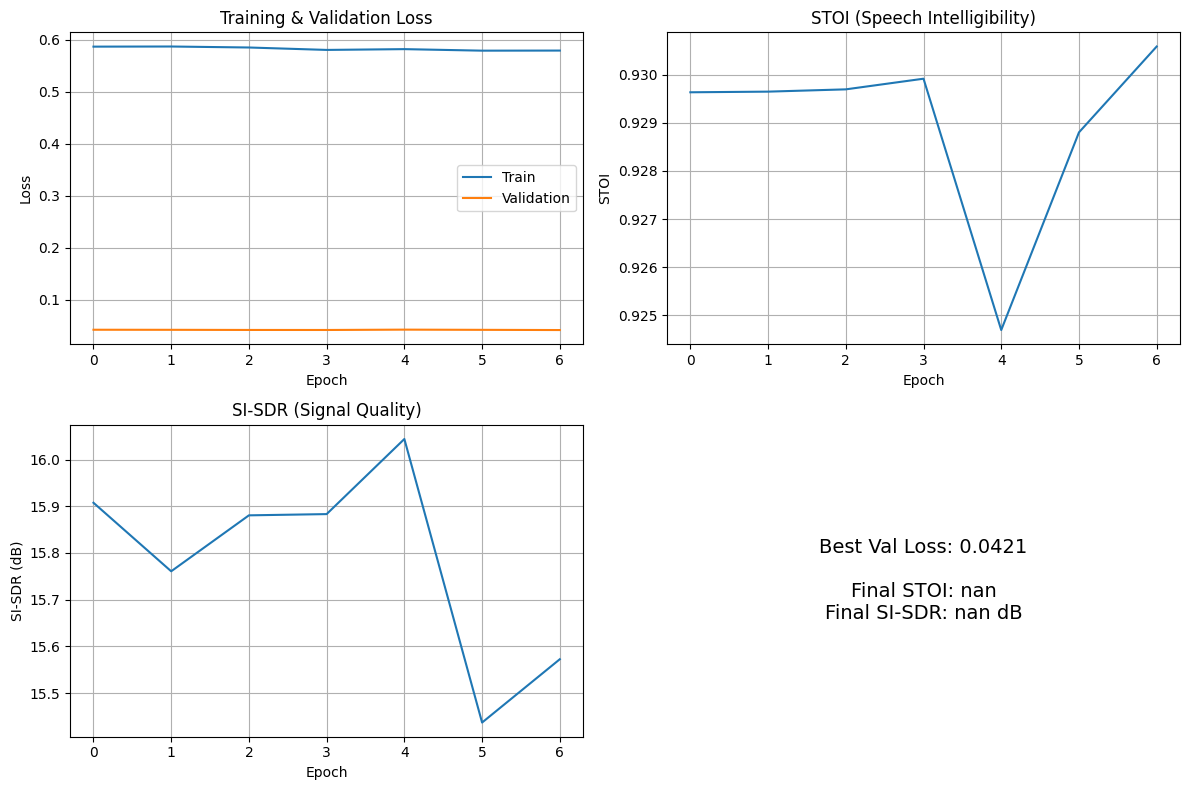

📊 Training history saved!


In [60]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss
axes[0, 0].plot(history['train_total_loss'], label='Train')
axes[0, 0].plot(history['val_total_loss'], label='Validation')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# STOI
axes[0, 1].plot(history['stoi'])
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('STOI')
axes[0, 1].set_title('STOI (Speech Intelligibility)')
axes[0, 1].grid(True)

# SI-SDR
axes[1, 0].plot(history['si_sdr'])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('SI-SDR (dB)')
axes[1, 0].set_title('SI-SDR (Signal Quality)')
axes[1, 0].grid(True)

# Summary
axes[1, 1].axis('off')
final_pesq = history['pesq'][-1] if history.get('pesq') else None
final_pesq = final_pesq if final_pesq is not None else 0.0
axes[1, 1].text(
    0.5,
    0.5,
    f"Best Val Loss: {best_val_loss:.4f}\n\n"
    f"Best SI-SDR: {best_si_sdr:.2f} dB\n\n"
    f"Final STOI: {history['stoi'][-1]:.3f}\n"
    f"Final SI-SDR: {history['si_sdr'][-1]:.2f} dB\n"
    f"Final SNR: {history['snr'][-1]:.2f} dB\n"
    f"Final PESQ: {final_pesq:.3f}",
    ha='center',
    va='center',
    fontsize=12,
    transform=axes[1, 1].transAxes,
)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

print("📊 Training history saved!")

## 6️⃣ Test Inference

In [61]:
# Load best model
best_path = ckpt_dir / 'best_model_sisdr.pt'
if not best_path.exists():
    best_path = ckpt_dir / 'best_model.pt'

checkpoint = torch.load(best_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

epoch = checkpoint.get('epoch', -1)
val_loss = checkpoint.get('val_loss', checkpoint.get('val_results', {}).get('total_loss', None))
si_sdr = checkpoint.get('si_sdr', checkpoint.get('val_results', {}).get('si_sdr', None))

print(f"✅ Loaded model from: {best_path}")
if epoch >= 0:
    print(f"   Epoch: {epoch + 1}")
if val_loss is not None:
    print(f"   Val total loss: {float(val_loss):.4f}")
if si_sdr is not None:
    print(f"   Val SI-SDR: {float(si_sdr):.2f} dB")

✅ Loaded best model from epoch 31
   Validation loss: 0.0421


In [62]:
# Test on a sample
import IPython.display as ipd

# Get a test sample
test_batch = next(iter(val_loader))
noisy_wav = test_batch['noisy'][0:1].to(device)
clean_wav = test_batch['clean'][0:1]
noisy_stft = test_batch['noisy_stft'][0:1].to(device)

# Denoise
with torch.no_grad():
    noisy_stft_input = noisy_stft.permute(0, 3, 1, 2)
    pred_stft = model(noisy_stft_input)
    pred_stft_out = pred_stft.permute(0, 2, 3, 1)
    denoised_wav = audio_processor.istft(pred_stft_out)

# Convert to numpy
noisy_np = noisy_wav[0].cpu().numpy()
clean_np = clean_wav[0].numpy()
denoised_np = denoised_wav[0].cpu().numpy()

# Ensure same length
min_len = min(len(noisy_np), len(clean_np), len(denoised_np))
noisy_np = noisy_np[:min_len]
clean_np = clean_np[:min_len]
denoised_np = denoised_np[:min_len]

print("🎧 Audio Comparison:")
print("\n1. Noisy Input:")
ipd.display(ipd.Audio(noisy_np, rate=CONFIG['data']['sample_rate']))

print("\n2. Denoised Output:")
ipd.display(ipd.Audio(denoised_np, rate=CONFIG['data']['sample_rate']))

print("\n3. Clean Reference:")
ipd.display(ipd.Audio(clean_np, rate=CONFIG['data']['sample_rate']))

🎧 Audio Comparison:

1. Noisy Input:



2. Denoised Output:



3. Clean Reference:


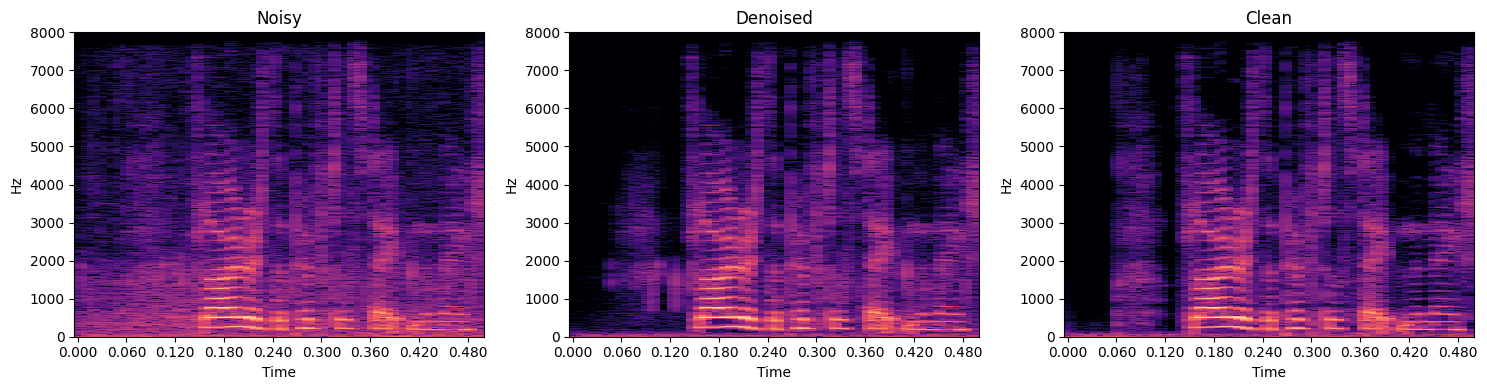

📊 Spectrogram comparison saved!


In [63]:
# Visualize spectrograms
import librosa
import librosa.display

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (audio, title) in zip(axes, [(noisy_np, 'Noisy'), (denoised_np, 'Denoised'), (clean_np, 'Clean')]):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=CONFIG['data']['sample_rate'], hop_length=128,
                            x_axis='time', y_axis='hz', ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 8000)

plt.tight_layout()
plt.savefig('spectrogram_comparison.png', dpi=150)
plt.show()

print("📊 Spectrogram comparison saved!")

## 7️⃣ Save Model to Google Drive

In [64]:
# ============================================
# 💾 XÁC NHẬN & BACKUP CUỐI CÙNG
# ============================================
# Cell này đảm bảo tất cả đã được lưu vào Google Drive

import shutil

save_path = Path(GDRIVE_MODEL_SAVE_PATH)
save_path.mkdir(parents=True, exist_ok=True)

print("="*60)
print("💾 KIỂM TRA VÀ BACKUP CUỐI CÙNG")
print("="*60)

# Danh sách các file cần backup
files_to_backup = [
    ('best_model.pt', ckpt_dir / 'best_model.pt'),
    ('best_model_sisdr.pt', ckpt_dir / 'best_model_sisdr.pt'),
    ('final_model.pt', ckpt_dir / 'final_model.pt'),
    ('latest_checkpoint.pt', ckpt_dir / 'latest_checkpoint.pt'),
    ('training_history.png', Path('training_history.png')),
    ('spectrogram_comparison.png', Path('spectrogram_comparison.png')),
]

print(f"\n📂 Đang backup vào: {save_path}")
print("-"*50)

backed_up = []
for name, src_path in files_to_backup:
    if src_path.exists():
        dest_path = save_path / name
        # Chỉ copy nếu chưa có hoặc file mới hơn
        if not dest_path.exists() or src_path.stat().st_mtime > dest_path.stat().st_mtime:
            shutil.copy(src_path, dest_path)
            backed_up.append(name)
            print(f"  ✅ {name} -> Google Drive")
        else:
            print(f"  ⏭️ {name} (đã có trên Drive)")
    else:
        print(f"  ⚠️ {name} (không tồn tại)")

print("-"*50)
print(f"\n📁 Nội dung trên Google Drive ({save_path}):")
if save_path.exists():
    for f in sorted(save_path.iterdir()):
        size_mb = f.stat().st_size / (1024*1024)
        print(f"   📄 {f.name} ({size_mb:.1f} MB)")
else:
    print("   ❌ Folder không tồn tại")

print("\n" + "="*60)
print("✅ BACKUP HOÀN TẤT!")
print("="*60)
print(f"\n📋 Để sử dụng model đã train:")
print(f"   - Best by loss:   {save_path / 'best_model.pt'}")
print(f"   - Best by SI-SDR: {save_path / 'best_model_sisdr.pt'}")
print(f"   - Hoặc download các file .pt về máy tính")

💾 KIỂM TRA VÀ BACKUP CUỐI CÙNG

📂 Đang backup vào: /content/drive/MyDrive/speech_denoising_models
--------------------------------------------------
  ⏭️ best_model.pt (đã có trên Drive)
  ⏭️ final_model.pt (đã có trên Drive)
  ✅ latest_checkpoint.pt -> Google Drive
  ✅ training_history.png -> Google Drive
  ✅ spectrogram_comparison.png -> Google Drive
--------------------------------------------------

📁 Nội dung trên Google Drive (/content/drive/MyDrive/speech_denoising_models):
   📄 best_model.pt (371.2 MB)
   📄 checkpoint_epoch_10.pt (371.2 MB)
   📄 checkpoint_epoch_15.pt (371.2 MB)
   📄 checkpoint_epoch_25.pt (371.2 MB)
   📄 checkpoint_epoch_30.pt (371.2 MB)
   📄 checkpoint_epoch_35.pt (371.2 MB)
   📄 checkpoint_epoch_40.pt (371.2 MB)
   📄 checkpoint_epoch_5.pt (371.2 MB)
   📄 final_checkpoint.pt (371.2 MB)
   📄 final_model.pt (371.2 MB)
   📄 latest_checkpoint.pt (371.2 MB)
   📄 spectrogram_comparison.png (0.3 MB)
   📄 training_history.png (0.1 MB)

✅ BACKUP HOÀN TẤT!

📋 Để sử dụn

In [65]:
# Optional: Download to local machine
from google.colab import files

print("📥 Downloading trained model...")
files.download(str(ckpt_dir / 'best_model.pt'))
print("\n✅ Download started! Check your browser downloads.")

📥 Downloading trained model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download started! Check your browser downloads.


---

## 📝 Notes

### Hướng dẫn sử dụng
1. Upload dataset lên Google Drive với cấu trúc thư mục đúng
2. Sửa `GDRIVE_DATASET_FOLDER` nếu tên thư mục khác
3. Chạy từng cell từ đầu đến cuối
4. Model sẽ được lưu vào Google Drive sau khi train xong

### Training Tips
- **Thời gian**: ~1-2 giờ trên Colab GPU (T4) cho 50 epochs
- **Memory**: Model sử dụng ~4-6GB GPU memory với batch size 8
- **Tăng epochs**: Đổi `num_epochs` thành 100 để có kết quả tốt hơn
- Check GPU: `!nvidia-smi`

### Sau khi train
- Model được lưu tại `./checkpoints/best_model.pt`
- Section 7 sẽ copy model lên Google Drive để lưu trữ
- Có thể download model về máy local